In [ ]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [1]:


# Read in the data
rawDF = pd.read_csv("Cancer_Data.csv")

# Take a peek at the data
rawDF.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
# Drop the 'id' column as its useless to us
rawDF = rawDF.drop(["Unnamed: 32","id"], axis = 1)

# Let's also change diagnosis into a numeric binary variable
rawDF.diagnosis = [1 if each == "M" else 0 for each in rawDF.diagnosis]

# Let's take a deeper look at the data and use the describe function
rawDF.describe()

In [4]:
# Let's also use a for loop to check for NA values
for col in rawDF:
    naCount = rawDF[col].isna().sum()
    print(f"The number of NA values in the {col} col is {naCount}")

The number of NA values in the diagnosis col is 0
The number of NA values in the radius_mean col is 0
The number of NA values in the texture_mean col is 0
The number of NA values in the perimeter_mean col is 0
The number of NA values in the area_mean col is 0
The number of NA values in the smoothness_mean col is 0
The number of NA values in the compactness_mean col is 0
The number of NA values in the concavity_mean col is 0
The number of NA values in the concave points_mean col is 0
The number of NA values in the symmetry_mean col is 0
The number of NA values in the fractal_dimension_mean col is 0
The number of NA values in the radius_se col is 0
The number of NA values in the texture_se col is 0
The number of NA values in the perimeter_se col is 0
The number of NA values in the area_se col is 0
The number of NA values in the smoothness_se col is 0
The number of NA values in the compactness_se col is 0
The number of NA values in the concavity_se col is 0
The number of NA values in the 

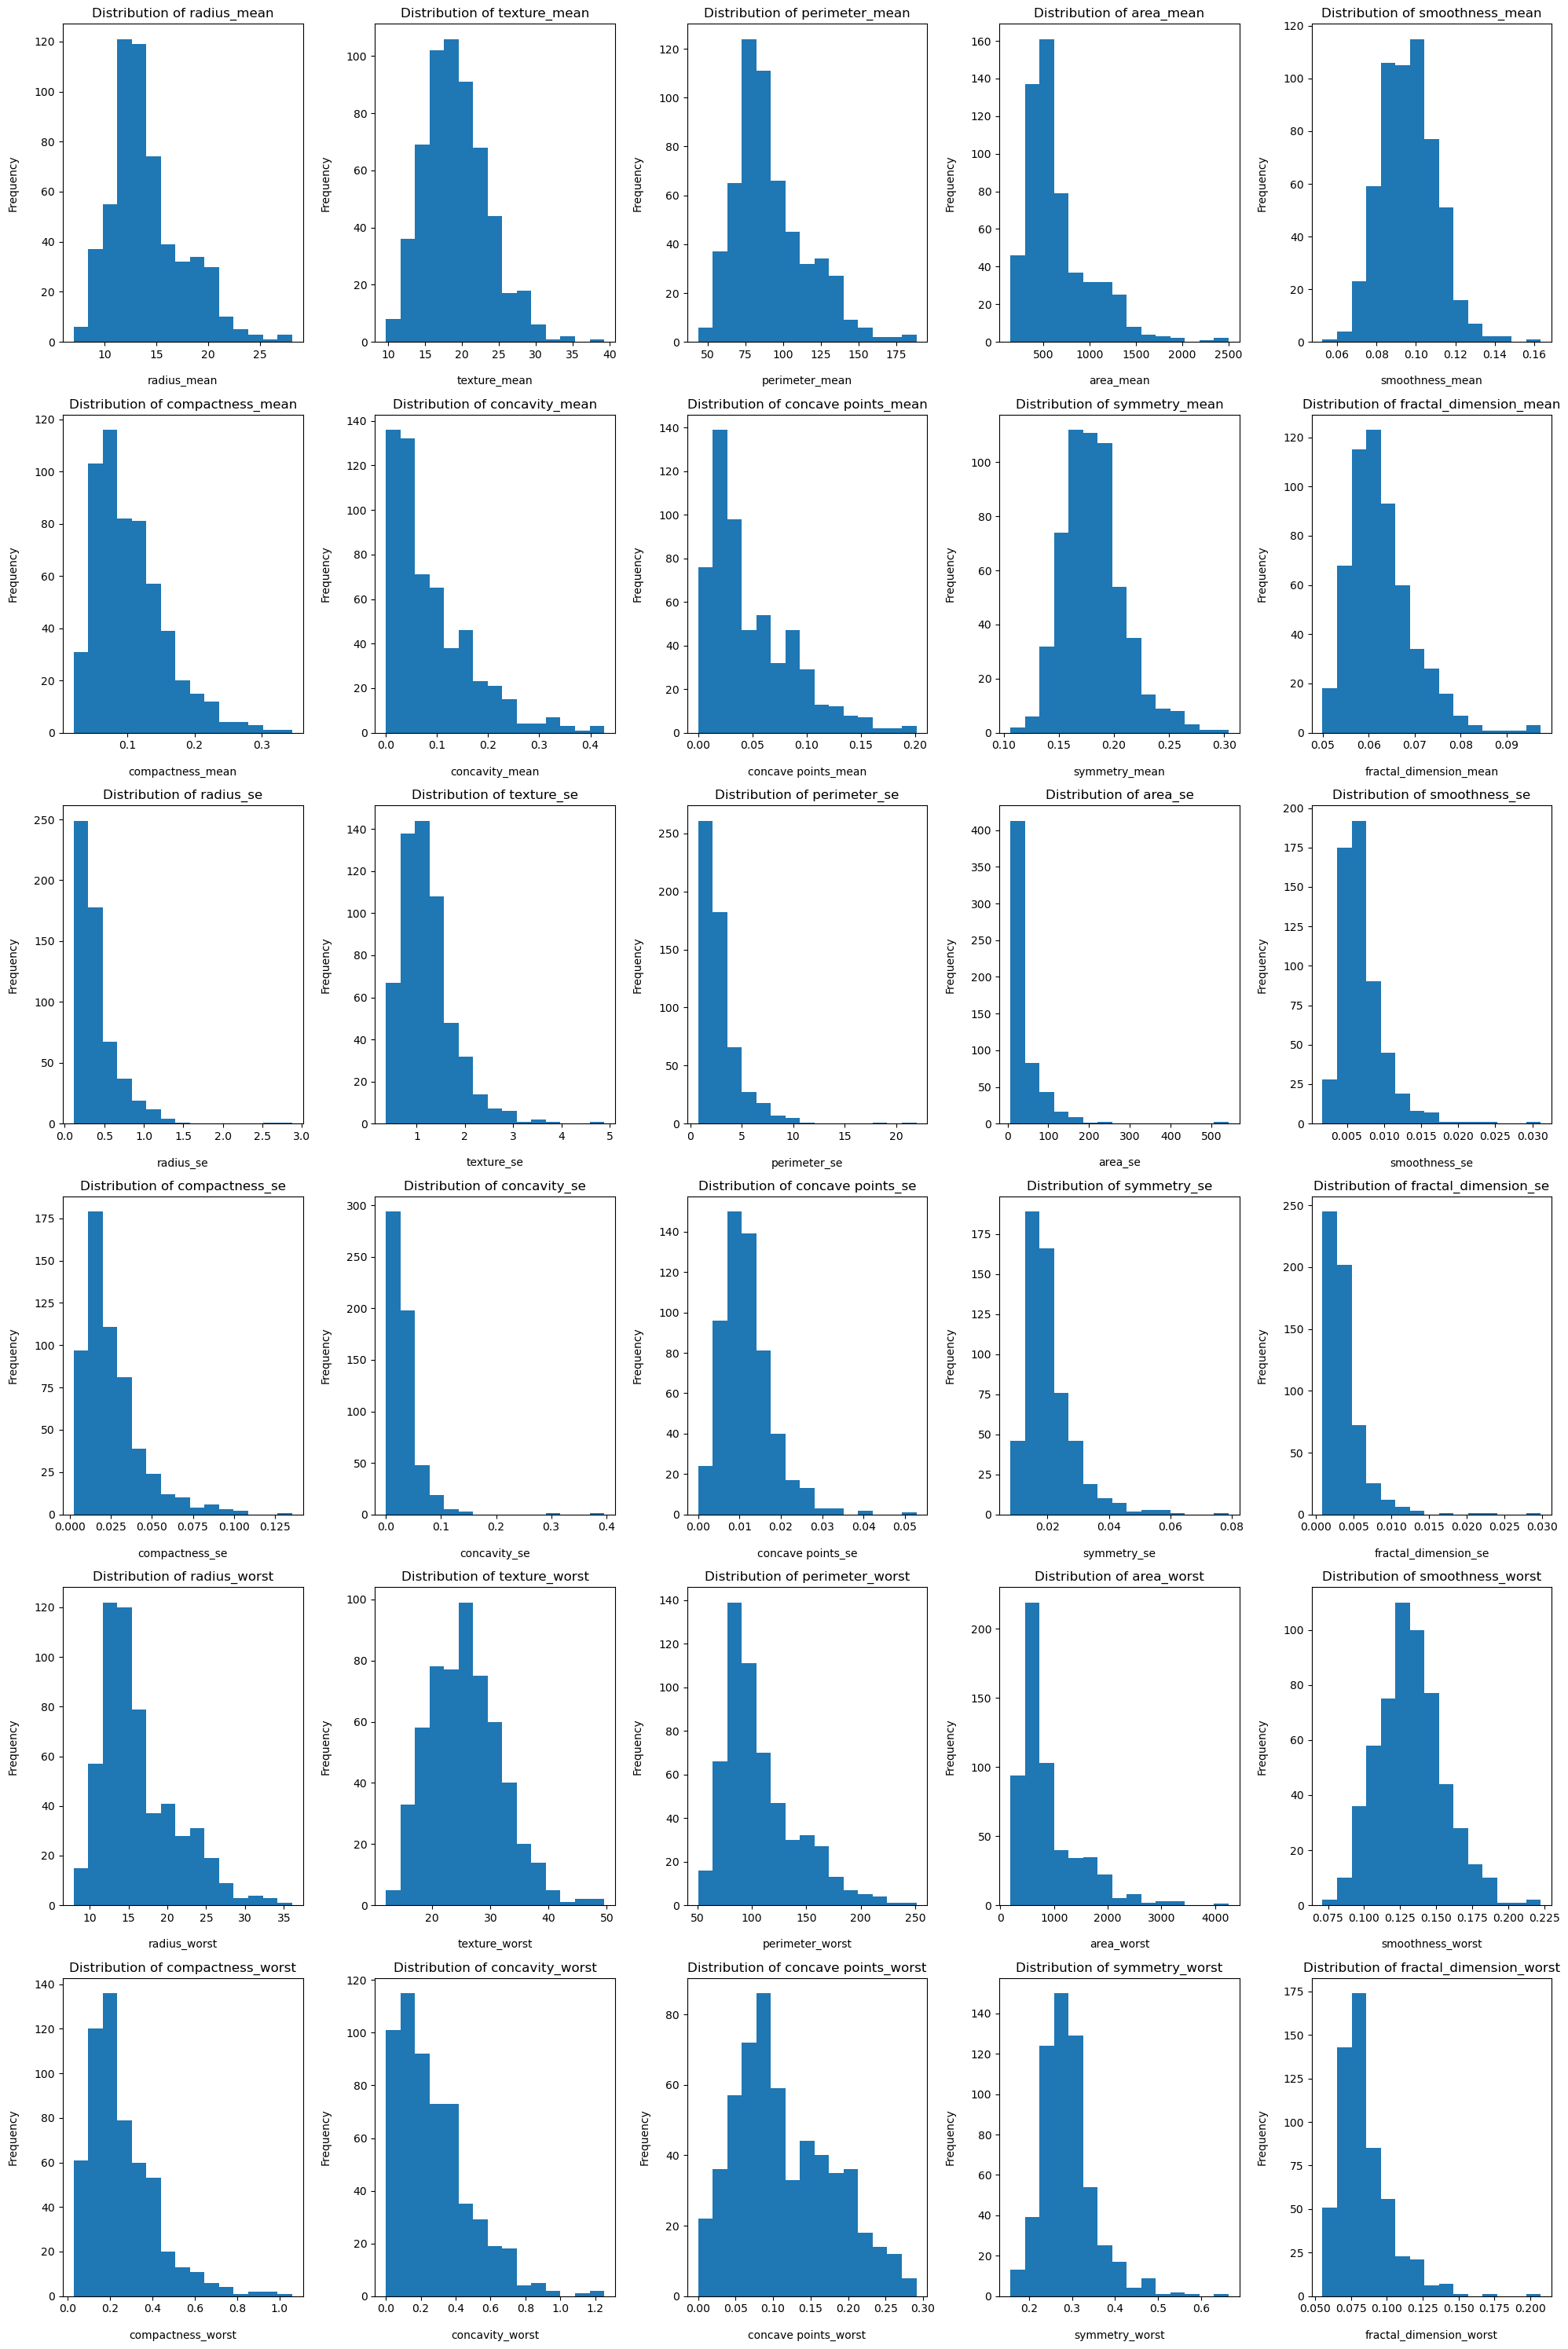

In [5]:
# Visualization Functions

# This function generates histograms for each feature to show the distribution of the data
def generateHistograms(rawDF, column_names):
    n_cols = 5
    n_rows = (len(column_names) + n_cols - 1) // n_cols
    axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axs = axs.flatten()
    
    for i, col in enumerate(column_names):
        axs[i].hist(rawDF[col].dropna(), bins=15)
        axs[i].set_xlabel(col, labelpad=14)
        axs[i].set_ylabel("Frequency", labelpad=14)
        axs[i].set_title(f"Distribution of {col}")

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# This function generates boxplots for each feature to show outliers
# That said, we may not need to worry about outliers in the context of this data
def generateBoxplots(rawDF, column_names):
    n_cols = 5
    n_rows = (len(column_names) + n_cols - 1) // n_cols
    axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axs = axs.flatten()
    
    for i, col in enumerate(column_names):
        sns.boxplot(x=rawDF[col], ax=axs[i])
        axs[i].set_title(f"Boxplot of {col}")

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

columns_to_plot = rawDF.columns.drop('diagnosis')
generateHistograms(rawDF, columns_to_plot)
generateBoxplots(rawDF, columns_to_plot)

c:\Users\ethan\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


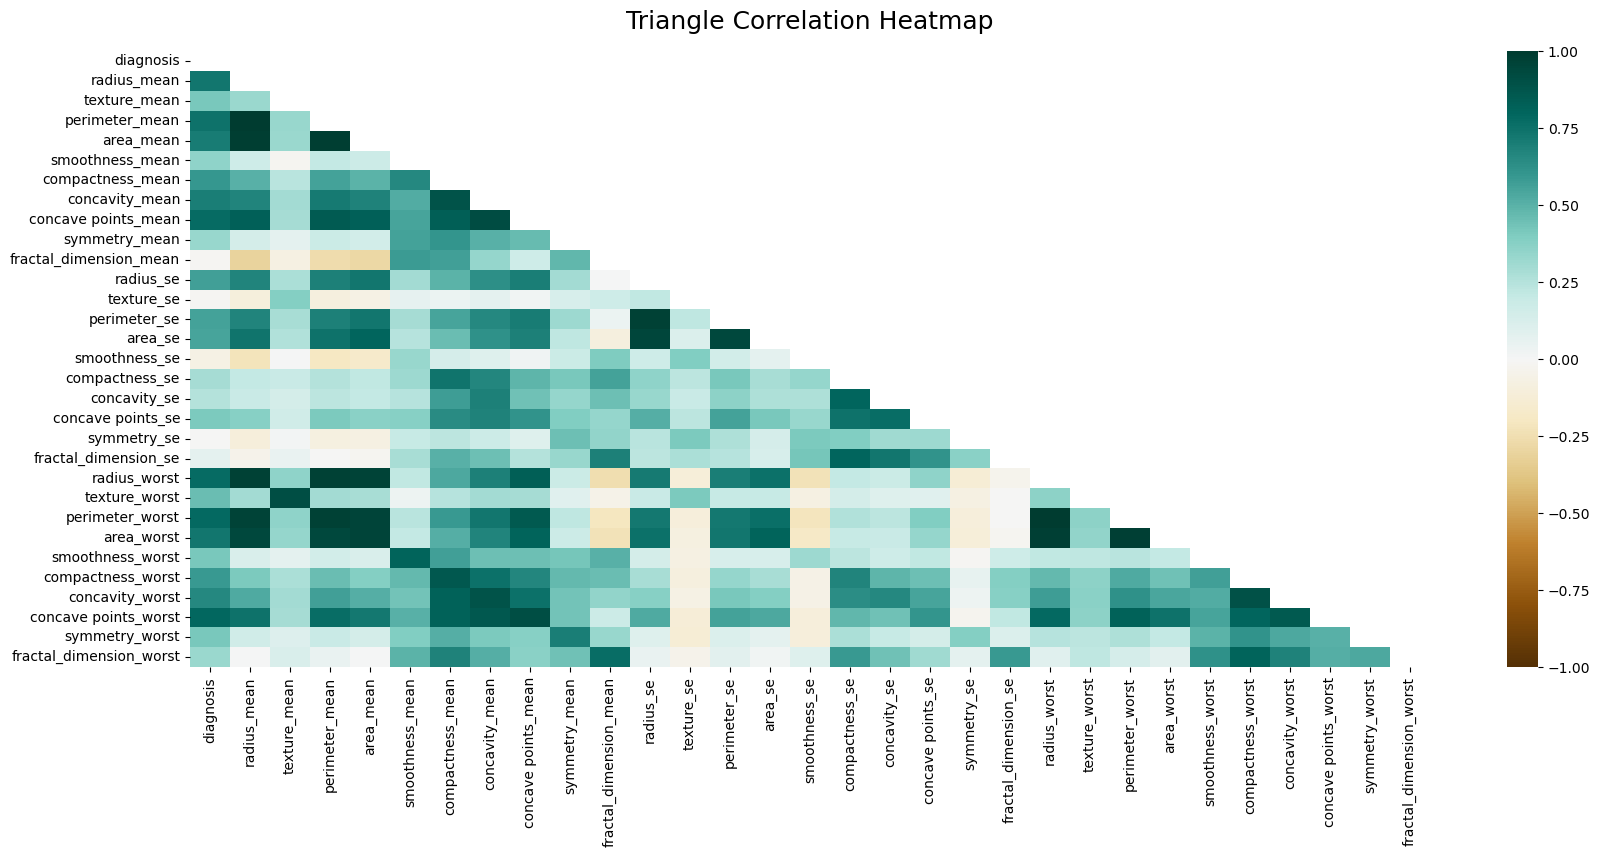

In [7]:
# Triangle Correlation Heatmap
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(rawDF.corr(), dtype=bool))
heatmap = sns.heatmap(rawDF.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Splitting Data

yDF = rawDF["diagnosis"]
xDF = rawDF.drop(columns=["diagnosis"], axis=1)

xTrain, xTest, yTrain, yTest = train_test_split(
    xDF, yDF, 
    test_size=0.05,
    shuffle = True,
    random_state=42)

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [ ]:
# Include SMOTE to handle class imbalance

smote = SMOTE(random_state=42)
xTrainBalanced, yTrainBalanced = smote.fit_resample(xTrain, yTrain)

In [ ]:
# Feature Selection

select = SelectKBest(f_classif, k=25)
xTrainSelect = select.fit_transform(xTrainBalanced, yTrainBalanced)
xTestSelect = select.transform(xTest)

In [11]:
xScaler = StandardScaler()
xColNames = xTrain.columns.values.tolist()
# train the scaler and apply it to the training set
xTrainScaled = xScaler.fit_transform(xTrain[xColNames])

In [13]:
parameters = {'penalty': ['l1', 'l2'], 
            'C': [0.01, 0.1, 1, 2, 4, 6],
            'solver': ['liblinear']}
gridSearch = GridSearchCV(estimator = LogisticRegression(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0,
                           n_jobs=-1)


gridSearch.fit(xTrainScaled, yTrain) 

logisticParams = gridSearch.best_params_

logisticParams

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [14]:
parameters = {'C':[0.1, 0.5, 1, 10,100,1000],
              'gamma':[3, 2, 1, 0.1, 0.001, 0.0001], 
              'kernel':['linear','rbf']}
gridSearch = GridSearchCV(estimator = SVC(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0,
                           n_jobs=-1)


gridSearch.fit(xTrainScaled, yTrain) 

svmParams = gridSearch.best_params_

svmParams

{'C': 0.1, 'gamma': 3, 'kernel': 'linear'}

In [15]:
parameters = parameter_space = {
    'max_iter': [1000],
    'hidden_layer_sizes': [(50,50), (50,50,50), (100)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05, 0.5, 0.1],
    'learning_rate': ['constant','adaptive'],
}
gridSearch = GridSearchCV(estimator = MLPClassifier(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0,
                           n_jobs=-1)


gridSearch.fit(xTrainScaled, yTrain) 

mlpParams = gridSearch.best_params_

mlpParams

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'solver': 'adam'}

In [16]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 6],
              'max_features': [None, 'sqrt', 'log2']}

              
gridSearch = GridSearchCV(estimator = DecisionTreeClassifier(),  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5,
                           verbose=0)


gridSearch.fit(xTrainScaled, yTrain) 

treeParams = gridSearch.best_params_

treeParams

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'random'}

In [17]:
parameters = {
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [0.5, 1, 2, 3, 5, 10],
    'min_samples_leaf': [0.1, 0.5, 1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_gridSearch = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=parameters,
                             scoring='recall',
                             cv=5,
                             verbose=0,
                             n_jobs=-1)  # Use all available CPUs

rf_gridSearch.fit(xTrainScaled, yTrain)

rfParams = rf_gridSearch.best_params_
rfParams



c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\ethan\anaconda3\Lib\site-p

{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [18]:
parameters = {
    'n_neighbors': [0.5, 1, 2, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_gridSearch = GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid=parameters,
                              scoring='recall',
                              cv=5,
                              verbose=0,
                              n_jobs=-1)

knn_gridSearch.fit(xTrainScaled, yTrain)

knnParams = knn_gridSearch.best_params_
knnParams


c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 213, in fit
    self._validate_params()
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\ethan\anaconda3\Lib\si

{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = LogisticRegression(**logisticParams)
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

## Calculate the mean scores across all folds
mean_score = sum(accuracyScores) / len(accuracyScores)
print("Mean accuracy score:", mean_score)

mean_score = sum(f1Scores) / len(f1Scores)
print("Mean f1 score:", mean_score)

mean_score = sum(precisionScores) / len(precisionScores)
print("Mean precision score:", mean_score)

mean_score = sum(recallScores) / len(recallScores)
print("Mean recall score:", mean_score)

Completed Fold 0
    Accuracy=0.9074074074074074    Recall=0.9285714285714286    FScore=0.8863636363636365
Completed Fold 1
    Accuracy=0.9351851851851852    Recall=0.9777777777777777    FScore=0.9263157894736842
Completed Fold 2
    Accuracy=0.9074074074074074    Recall=0.972972972972973    FScore=0.8780487804878049
Completed Fold 3
    Accuracy=0.9537037037037037    Recall=0.9787234042553191    FScore=0.9484536082474226
Completed Fold 4
    Accuracy=0.9537037037037037    Recall=0.9428571428571428    FScore=0.9295774647887323
Mean accuracy score: 0.9314814814814815
Mean f1 score: 0.9137518558722559
Mean precision score: 0.8728985507246378
Mean recall score: 0.9601805452869282


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = DecisionTreeClassifier(**treeParams)
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

## Calculate the mean scores across all folds
mean_score = sum(accuracyScores) / len(accuracyScores)
print("Mean accuracy score:", mean_score)

mean_score = sum(f1Scores) / len(f1Scores)
print("Mean f1 score:", mean_score)

mean_score = sum(precisionScores) / len(precisionScores)
print("Mean precision score:", mean_score)

mean_score = sum(recallScores) / len(recallScores)
print("Mean recall score:", mean_score)

Completed Fold 0
    Accuracy=0.9814814814814815    Recall=0.9761904761904762    FScore=0.9761904761904762
Completed Fold 1
    Accuracy=0.9814814814814815    Recall=0.9555555555555556    FScore=0.9772727272727273
Completed Fold 2
    Accuracy=0.9722222222222222    Recall=0.972972972972973    FScore=0.9599999999999999
Completed Fold 3
    Accuracy=0.9907407407407407    Recall=1.0    FScore=0.9894736842105264
Completed Fold 4
    Accuracy=0.9814814814814815    Recall=0.9428571428571428    FScore=0.9705882352941176
Mean accuracy score: 0.9814814814814815
Mean f1 score: 0.9747050245935694
Mean precision score: 0.9805451127819549
Mean recall score: 0.9695152295152296


In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = SVC(**svmParams)
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

## Calculate the mean scores across all folds
mean_score = sum(accuracyScores) / len(accuracyScores)
print("Mean accuracy score:", mean_score)

mean_score = sum(f1Scores) / len(f1Scores)
print("Mean f1 score:", mean_score)

mean_score = sum(precisionScores) / len(precisionScores)
print("Mean precision score:", mean_score)

mean_score = sum(recallScores) / len(recallScores)
print("Mean recall score:", mean_score)



Completed Fold 0
    Accuracy=0.9722222222222222    Recall=0.9523809523809523    FScore=0.963855421686747
Completed Fold 1
    Accuracy=0.9814814814814815    Recall=0.9555555555555556    FScore=0.9772727272727273
Completed Fold 2
    Accuracy=0.9814814814814815    Recall=0.972972972972973    FScore=0.972972972972973
Completed Fold 3
    Accuracy=0.9814814814814815    Recall=0.9574468085106383    FScore=0.9782608695652174
Completed Fold 4
    Accuracy=0.9629629629629629    Recall=0.8857142857142857    FScore=0.9393939393939393
Mean accuracy score: 0.975925925925926
Mean f1 score: 0.9663511861783208
Mean precision score: 0.9897165458141067
Mean recall score: 0.9448141150268811


In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracyScores = []
f1Scores = []
precisionScores = []
recallScores = []
aucScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):

    ### making training and validation sets
    # Convert indices to list
    trainIndex = trainIndex.tolist()
    valIndex = valIndex.tolist()
    
    # Split the data into training and validation sets for this fold
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xDF.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yDF.iloc[valIndex]


    ### feature scaling
    xScaler = StandardScaler()
    xColNames = xLocalTrain.columns.values.tolist()
    # train the scaler and apply it to the training set
    xTrainScaled = xScaler.fit_transform(xLocalTrain[xColNames])
    # apply the scaling to the validation set
    xValScaled = xScaler.transform(xVal[xColNames])

    ### model training
    # instantiate the model
    clf = MLPClassifier(**mlpParams)
    # Train the classifier on the training data
    clf.fit(xTrainScaled, yLocalTrain)
    
    ### model prediction and evaluation
    # Make predictions on the test data
    yPred = clf.predict(xValScaled)

    # Calculate metrics and store them
    score = accuracy_score(yVal, yPred)
    accuracyScores.append(score)

    score = f1_score(yVal, yPred)
    f1Scores.append(score)

    score = precision_score(yVal, yPred)
    precisionScores.append(score)

    score = recall_score(yVal, yPred)
    recallScores.append(score)

    print(f"Completed Fold {i}")
    print(f"    Accuracy={accuracyScores[i]}    Recall={recallScores[i]}    FScore={f1Scores[i]}")

## Calculate the mean scores across all folds
mean_score = sum(accuracyScores) / len(accuracyScores)
print("Mean accuracy score:", mean_score)

mean_score = sum(f1Scores) / len(f1Scores)
print("Mean f1 score:", mean_score)

mean_score = sum(precisionScores) / len(precisionScores)
print("Mean precision score:", mean_score)

mean_score = sum(recallScores) / len(recallScores)
print("Mean recall score:", mean_score)

Completed Fold 0
    Accuracy=0.9907407407407407    Recall=1.0    FScore=0.988235294117647
Completed Fold 1
    Accuracy=0.9907407407407407    Recall=0.9777777777777777    FScore=0.9887640449438202
Completed Fold 2
    Accuracy=0.9814814814814815    Recall=0.972972972972973    FScore=0.972972972972973
Completed Fold 3
    Accuracy=0.9907407407407407    Recall=0.9787234042553191    FScore=0.989247311827957
Completed Fold 4
    Accuracy=0.9814814814814815    Recall=0.9428571428571428    FScore=0.9705882352941176
Mean accuracy score: 0.987037037037037
Mean f1 score: 0.981961571831303
Mean precision score: 0.9899434318038969
Mean recall score: 0.9744662595726424


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_accuracyScores = []
knn_f1Scores = []
knn_precisionScores = []
knn_recallScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):
    # Split the data
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xTrain.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yTrain.iloc[valIndex]

    # Feature scaling
    xScaler = StandardScaler()
    xTrainScaled = xScaler.fit_transform(xLocalTrain)
    xValScaled = xScaler.transform(xVal)

    # Instantiate and train the KNN classifier
    knn = KNeighborsClassifier(**knnParams)  # Assuming knnParams is predefined
    knn.fit(xTrainScaled, yLocalTrain)

    # Predict and evaluate
    yPred = knn.predict(xValScaled)
    knn_accuracyScores.append(accuracy_score(yVal, yPred))
    knn_f1Scores.append(f1_score(yVal, yPred))
    knn_precisionScores.append(precision_score(yVal, yPred))
    knn_recallScores.append(recall_score(yVal, yPred))

    print(f"Completed Fold {i}")
    print(f"    Accuracy={knn_accuracyScores[i]}    Recall={knn_recallScores[i]}    FScore={knn_f1Scores[i]}")

# Calculate the mean scores across all folds for KNN
print("KNN Mean accuracy score:", np.mean(knn_accuracyScores))
print("KNN Mean f1 score:", np.mean(knn_f1Scores))
print("KNN Mean precision score:", np.mean(knn_precisionScores))
print("KNN Mean recall score:", np.mean(knn_recallScores))


Completed Fold 0
    Accuracy=0.9444444444444444    Recall=0.9024390243902439    FScore=0.9249999999999999
Completed Fold 1
    Accuracy=1.0    Recall=1.0    FScore=1.0
Completed Fold 2
    Accuracy=0.9259259259259259    Recall=0.975609756097561    FScore=0.9090909090909092
Completed Fold 3
    Accuracy=0.9537037037037037    Recall=0.95    FScore=0.9382716049382716
Completed Fold 4
    Accuracy=0.9444444444444444    Recall=0.875    FScore=0.9210526315789473
KNN Mean accuracy score: 0.9537037037037036
KNN Mean f1 score: 0.9386830291216256
KNN Mean precision score: 0.9397666538040175
KNN Mean recall score: 0.940609756097561


In [25]:
rf_accuracyScores = []
rf_f1Scores = []
rf_precisionScores = []
rf_recallScores = []

for i, (trainIndex, valIndex) in enumerate(cv.split(xTrain, yTrain)):
    # Split the data
    xLocalTrain, xVal = xTrain.iloc[trainIndex], xTrain.iloc[valIndex]
    yLocalTrain, yVal = yTrain.iloc[trainIndex], yTrain.iloc[valIndex]

    # Feature scaling (optional for RF but maintaining consistency)
    xScaler = StandardScaler()
    xTrainScaled = xScaler.fit_transform(xLocalTrain)
    xValScaled = xScaler.transform(xVal)

    # Instantiate and train the RF classifier
    rf = RandomForestClassifier(**rfParams)  # Assuming rfParams is predefined
    rf.fit(xTrainScaled, yLocalTrain)

    # Predict and evaluate
    yPred = rf.predict(xValScaled)
    rf_accuracyScores.append(accuracy_score(yVal, yPred))
    rf_f1Scores.append(f1_score(yVal, yPred))
    rf_precisionScores.append(precision_score(yVal, yPred))
    rf_recallScores.append(recall_score(yVal, yPred))

    print(f"Completed Fold {i}")
    print(f"    Accuracy={rf_accuracyScores[i]}    Recall={rf_recallScores[i]}    FScore={rf_f1Scores[i]}")

# Calculate the mean scores across all folds for RF
print("RF Mean accuracy score:", np.mean(rf_accuracyScores))
print("RF Mean f1 score:", np.mean(rf_f1Scores))
print("RF Mean precision score:", np.mean(rf_precisionScores))
print("RF Mean recall score:", np.mean(rf_recallScores))


Completed Fold 0
    Accuracy=0.9259259259259259    Recall=0.9024390243902439    FScore=0.9024390243902439
Completed Fold 1
    Accuracy=0.9166666666666666    Recall=0.9512195121951219    FScore=0.8965517241379309
Completed Fold 2
    Accuracy=0.9722222222222222    Recall=0.9512195121951219    FScore=0.9629629629629629
Completed Fold 3
    Accuracy=0.9629629629629629    Recall=0.975    FScore=0.951219512195122
Completed Fold 4
    Accuracy=0.9444444444444444    Recall=0.85    FScore=0.9189189189189189
RF Mean accuracy score: 0.9444444444444444
RF Mean f1 score: 0.9264184285210357
RF Mean precision score: 0.9307673079836389
RF Mean recall score: 0.9259756097560976


In [26]:
### feature scaling
xScaler = StandardScaler()
xColNames = xLocalTrain.columns.values.tolist()
# train the scaler and apply it to the training set
xTrainScaled = xScaler.fit_transform(xTrain[xColNames])
# apply the scaling to the testing set
xTestScaled = xScaler.transform(xTest[xColNames])

In [27]:
################ 
# Logistic Regression
################
clf = LogisticRegression(**logisticParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

lrAccuracy = accuracy_score(yTest, preds)
lrFScore = f1_score(yTest, preds)
lrPrecision = precision_score(yTest, preds)
lrRecall = recall_score(yTest, preds)

################ 
# Neural Net
################
clf = MLPClassifier(**mlpParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

nnAccuracy = accuracy_score(yTest, preds)
nnFScore = f1_score(yTest, preds)
nnPrecision = precision_score(yTest, preds)
nnRecall = recall_score(yTest, preds)

################ 
# Decision Tree
################
clf = DecisionTreeClassifier(**treeParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

treeAccuracy = accuracy_score(yTest, preds)
treeFScore = f1_score(yTest, preds)
treePrecision = precision_score(yTest, preds)
treeRecall = recall_score(yTest, preds)

################ 
# Random Forest
################
clf = RandomForestClassifier(**rfParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

rfAccuracy = accuracy_score(yTest, preds)
rfFScore = f1_score(yTest, preds)
rfPrecision = precision_score(yTest, preds)
rfRecall = recall_score(yTest, preds)

################ 
# K-NN
################
clf = KNeighborsClassifier(**knnParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

knnAccuracy = accuracy_score(yTest, preds)
knnFScore = f1_score(yTest, preds)
knnPrecision = precision_score(yTest, preds)
knnRecall = recall_score(yTest, preds)

################ 
# SVM
################

clf = SVC(**svmParams)
clf.fit(xTrainScaled, yTrain)

preds = clf.predict(xTestScaled)

svmAccuracy = accuracy_score(yTest, preds)
svmFScore = f1_score(yTest, preds)
svmPrecision = precision_score(yTest, preds)
svmRecall = recall_score(yTest, preds)

scoreDict = {"model" : ["Neural Network", "SVM", "K-NN", "Decision Tree", "RF", "LR"],
            "accuracy" : [nnAccuracy, svmAccuracy, knnAccuracy, treeAccuracy, rfAccuracy, lrAccuracy],
            "fScore" : [nnFScore, svmFScore, knnFScore, treeFScore, rfFScore, lrFScore],
            "precision" : [nnPrecision, svmPrecision, knnPrecision, treePrecision, rfPrecision, lrPrecision],
            "recall" : [nnRecall, svmRecall, knnRecall, treeRecall, rfRecall, lrRecall]}

resultsDF = pd.DataFrame.from_dict(scoreDict)

resultsDF

,model,accuracy,fScore,precision,recall
0,Neural Network,0.965517,0.941176,1.000000,0.888889
1,SVM,1.000000,1.000000,1.000000,1.000000
2,K-NN,0.965517,0.947368,0.900000,1.000000
3,Decision Tree,0.827586,0.666667,0.833333,0.555556
4,RF,1.000000,1.000000,1.000000,1.000000
5,LR,1.000000,1.000000,1.000000,1.000000


In [28]:
styled_results = resultsDF.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center'), ('color', 'black')]},
     {'selector': 'td', 'props': [('text-align', 'center'), ('color', 'black')]},
     {'selector': 'tr:nth-of-type(odd)', 'props': [('background', '#f5f5f5')]},
     {'selector': 'tr:nth-of-type(even)', 'props': [('background', 'white')]},
     {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
    ], overwrite=False)

styled_results = styled_results.format({
    'accuracy': '{:,.2f}'.format,
    'fScore': '{:,.2f}'.format,
    'precision': '{:,.2f}'.format,
    'recall': '{:,.2f}'.format
})

styled_results = styled_results.hide()

styled_results

model,accuracy,fScore,precision,recall
Neural Network,0.97,0.94,1.00,0.89
SVM,1.00,1.00,1.00,1.00
K-NN,0.97,0.95,0.90,1.00
Decision Tree,0.83,0.67,0.83,0.56
RF,1.00,1.00,1.00,1.00
LR,1.00,1.00,1.00,1.00
